# General exploration of sample and detector

## Purpose of this notebook

Goal of this notebook is to familiarize with tools provided to understand the detector properties and the check the sample content in terms of simulated neutrino interaction. This notebook focuses on the TPC detector, for an exploration of the optical system see "Optical Information.ipynb".

For further reading, see "Design and construction of the MicroBooNE detector" (R. Acciarri et al 2017 JINST 12 P02017, https://arxiv.org/abs/1612.05824)

## Load useful libraries, utilities, and data

First load standard libraries we make use of.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

The load specific utilities to access tools for handling our files (from the pynuml package) and for accessing simple detector information. Their usage is demonstrated in this notebook. 

In [2]:
from microboone_utils import *

In [3]:
from pynuml.io import File

We now load a data file, check how many events are in the file and the decide how many events we want to work on. Then we specify which tables we need in this notebook and load the data:

In [4]:
f = File("bnb_NoWire_00.h5")

In [5]:
print('Number of events in the file:',len(f))

Number of events in the file: 9002


In [6]:
startevt = 0
nevts = 2000 #anything from 0 to len(f)

In [7]:
print("Printing top-level keys (data tables):")
print(f.keys())

Printing top-level keys (data tables):
<KeysViewHDF5 ['edep_table', 'event_table', 'hit_table', 'opflash_table', 'opflashsumpe_table', 'ophit_table', 'pandoraHit_table', 'pandoraPfp_table', 'pandoraPrimary_table', 'particle_table']>


In [8]:
tables = ['event_table','hit_table','particle_table','pandoraHit_table']

In [9]:
for t in tables: f.add_group(t)
f.read_data(startevt, nevts)

## Accessing the data

The pynuml File class provides two ways to access the data. Both access patterns rely on the concept of event, defined as each independent readout of the detector.
1. As a list of pandas data frames across events
2. As unique data frame with a column "evt_idx" that separates the different events

Here we demonstrate how to compute the average number of hits per event using the two methods.
In general, method 1. is better designed for processing of event by event data (e.g. developing a new algorithm), while 2. is better suited for extracting information across events (e.g. for performance evaluation). Therefore, in these notebooks we'll mostly rely on method 2., but we expect 1. to be more convenient for new developments.

In [10]:
evts = f.build_evt()
nhits = [ len(evt['hit_table']) for evt in evts]
np.average(nhits)

15726.882

In [11]:
hits = f.get_dataframe_evt('hit_table')
nhits = hits.groupby('evt_idx').size()
np.average(nhits)

15726.882

## Detector wires

The following scans the wires in each plane, and plots the detector positions of wires in intervals of 200 wires.

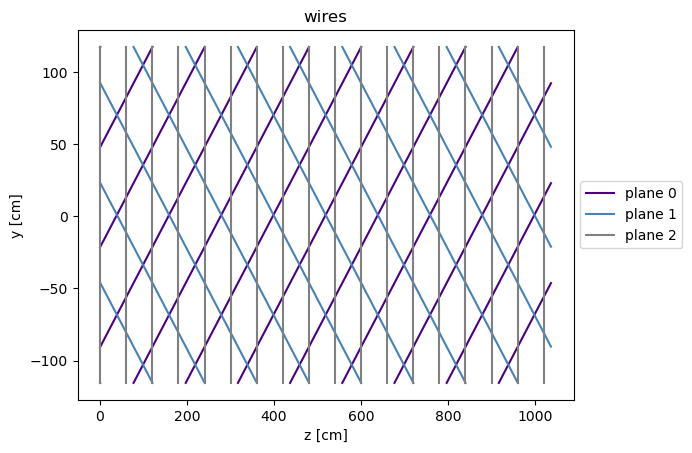

In [12]:
for p in range(0,nplanes()):
    color = 'grey'
    if p==0: color = 'indigo'
    if p==1: color = 'steelblue'
    for w in range(0,nwires(p),200):
        start = wireStartPos(p,w)
        end = wireEndPos(p,w)
        x = [start[2],end[2]]
        y = [start[1],end[1]]
        plt.plot(x, y, label = "plane %i"%p, linestyle="-",color=color)
plt.xlabel('z [cm]')
plt.ylabel('y [cm]')
plt.title('wires')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The following shows some utilities to check if two wires cross and compute their intersection point in the YZ plane.

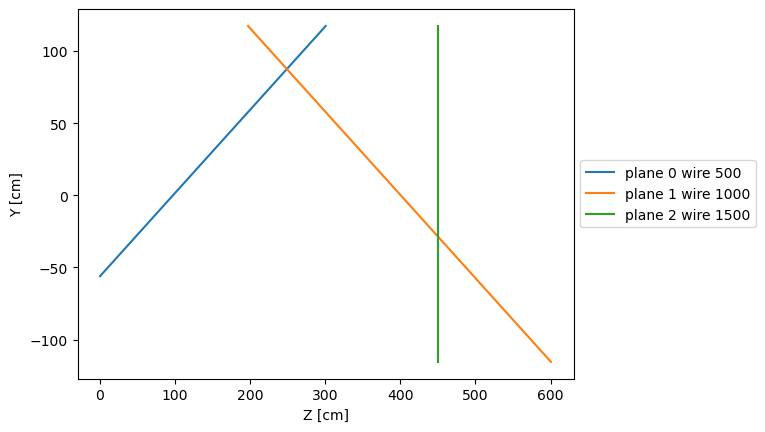

do plane 0 wire 500 and plane 1 wire 1000 cross? True
crossing: [87.57235399441043, 248.80003865905684]
do plane 1 wire 1000 and plane 2 wire 1500 cross? True
crossing: [-28.734615075765433, 450.25]
do plane 0 wire 500 and plane 2 wire 1500 cross? False


In [13]:
w0 = 500
w1 = 1000
w2 = 1500

start = wireStartPos(0,w0)
end = wireEndPos(0,w0)
x = [start[2],end[2]]
y = [start[1],end[1]]
plt.plot(x, y, label = "plane 0 wire %i"%w0, linestyle="-")

start = wireStartPos(1,w1)
end = wireEndPos(1,w1)
x = [start[2],end[2]]
y = [start[1],end[1]]
plt.plot(x, y, label = "plane 1 wire %i"%w1, linestyle="-")

start = wireStartPos(2,w2)
end = wireEndPos(2,w2)
x = [start[2],end[2]]
y = [start[1],end[1]]
plt.plot(x, y, label = "plane 2 wire %i"%w2, linestyle="-")

plt.xlabel('Z [cm]')
plt.ylabel('Y [cm]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print('do plane 0 wire %i and plane 1 wire %i cross?'%(w0,w1),doWiresCross(0,w0,1,w1))
if (doWiresCross(0,w0,1,w1)): print('crossing:',wireCrossingYZ(0,w0,1,w1))
print('do plane 1 wire %i and plane 2 wire %i cross?'%(w1,w2),doWiresCross(1,w1,2,w2))
if (doWiresCross(1,w1,2,w2)): print('crossing:',wireCrossingYZ(1,w1,2,w2))
print('do plane 0 wire %i and plane 2 wire %i cross?'%(w0,w2),doWiresCross(0,w0,2,w2))
if (doWiresCross(0,w0,2,w2)): print('crossing:',wireCrossingYZ(0,w0,2,w2))


We now check the hit multiplicity in each wire, to find out which wires are not functional or noisy.

In [14]:
hits.columns

Index(['hit_id', 'integral', 'local_plane', 'local_time', 'local_wire', 'rms',
       'tpc', 'evt_idx'],
      dtype='object')

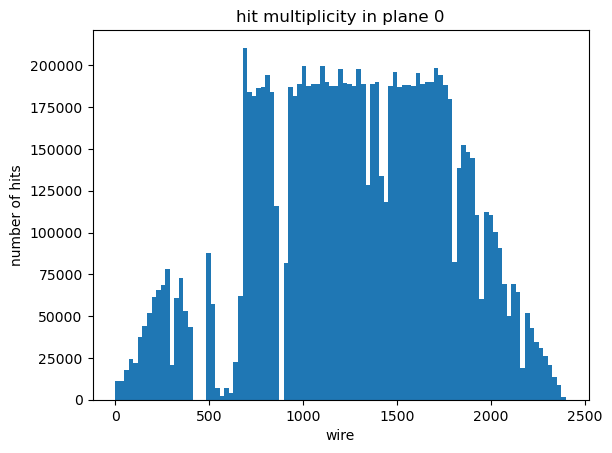

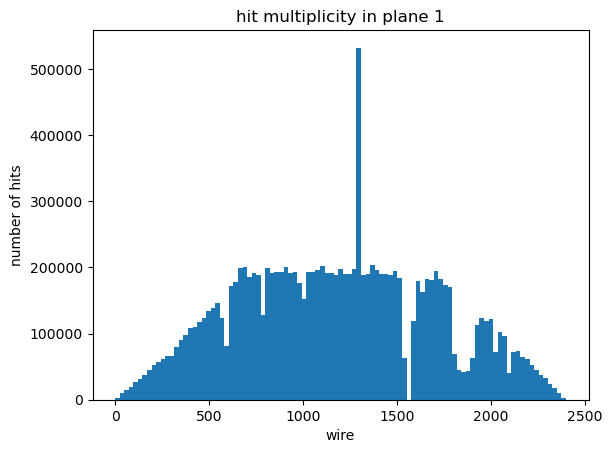

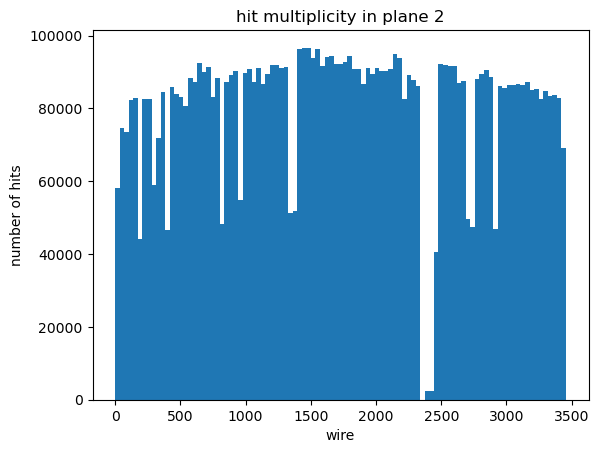

In [15]:
for p in range(0,nplanes()):
    plt.hist(hits.query("local_plane==%i"%p)["local_wire"],bins=(np.linspace(0,nwires(p),100)))
    plt.title("hit multiplicity in plane %i"%p)
    plt.xlabel("wire")
    plt.ylabel("number of hits")
    plt.show()

We can also check the number of hits that are clustered in 3D objectes (PFParticles) by the Pandora toolkit (see also `Pandora metrics.ipynb`). The information about clustered hits is in the `pandoraHit_table`, and clustered hits have non-negative `pfp_id`. With these requirements we can plot the clustered hit multiplicity in plane 1, and we do not observe anymore the spike around wire 1300, which is due to noise hits that are not clustered.

In [16]:
pandoraHit = f.get_dataframe_evt('pandoraHit_table')
hits = hits.merge(pandoraHit, on=["evt_idx","hit_id"], how="left")

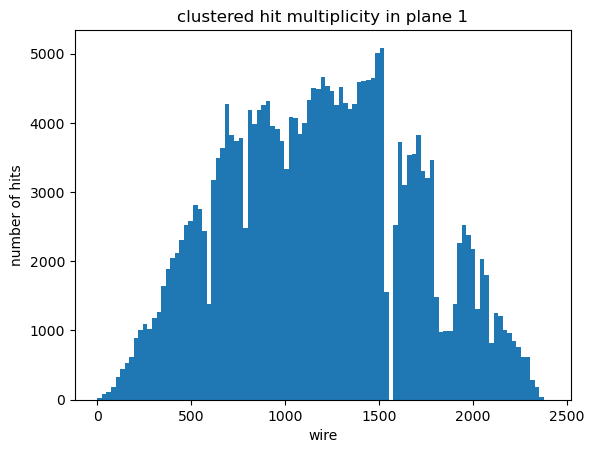

In [17]:
plt.hist(hits.query("local_plane==1 and pfp_id>=0")["local_wire"],bins=(np.linspace(0,nwires(1),100)))
plt.title("clustered hit multiplicity in plane 1")
plt.xlabel("wire")
plt.ylabel("number of hits")
plt.show()

## Simulated sample properties

The following plots the simulated neutrino interaction vertex position. For the inclusive BNB sample, this can take place anywhere in the cryostat, while for the nue samples interaction are restricted to the active detector volume.

In [18]:
events = f.get_dataframe_evt('event_table')
events

,run,subrun,event,is_cc,lep_energy,nu_dir_x,nu_dir_y,nu_dir_z,nu_energy,nu_pdg,...,nu_vtx_y,nu_vtx_z,nu_vtx_corr_x,nu_vtx_corr_y,nu_vtx_corr_z,nu_vtx_wire_pos_0,nu_vtx_wire_pos_1,nu_vtx_wire_pos_2,nu_vtx_wire_time,evt_idx
0,7694,172,8603,0,0.151762,0.006175,-0.001620,0.999980,0.290410,14,...,-13.845160,325.037476,261.464752,-13.267102,324.998322,918,836,1082,3523.265381,0
1,7694,172,8610,1,0.691527,-0.001290,-0.001623,0.999998,0.816768,14,...,-9.914882,1061.677979,-54.568832,-9.914882,1061.677979,2136,2073,3455,3400.318115,1
2,7694,174,8714,1,0.352848,0.002383,-0.001376,0.999996,0.926897,14,...,-10.333830,203.329941,49.511559,-10.183234,203.283997,706,642,677,4242.270020,2
3,7694,174,8717,1,0.287145,0.004299,-0.003777,0.999984,1.656710,14,...,-106.903366,552.198914,176.306488,-98.737923,552.239502,1544,968,1840,3957.855713,3
4,7694,174,8735,1,4.006666,0.001843,-0.000551,0.999998,4.466969,14,...,17.910742,972.227661,-23.170803,17.910742,972.227661,1907,2005,3240,4644.745605,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7003,1345,67263,0,0.272164,0.000050,0.000202,1.000000,1.718097,14,...,73.847542,182.333435,-32.973881,73.847542,182.333435,429,850,607,4378.857910,1995
1996,7003,1345,67264,1,0.262777,0.005295,-0.003073,0.999981,0.758674,14,...,-40.542336,302.203217,147.425934,-39.609501,302.165497,956,722,1006,4300.898926,1996
1997,7003,1345,67266,1,0.354550,0.000925,0.000759,0.999999,1.105731,14,...,101.754951,-4.713792,7.599277,101.726349,-4.703865,37,618,0,3528.938965,1997
1998,7003,1345,67267,0,0.119832,0.000336,-0.002014,0.999998,0.734521,14,...,-0.672465,-2.247888,-1.536085,-0.672465,-2.247888,336,327,0,3156.582031,1998


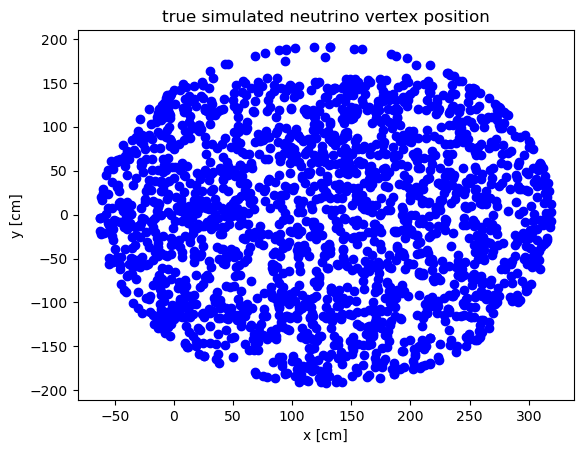

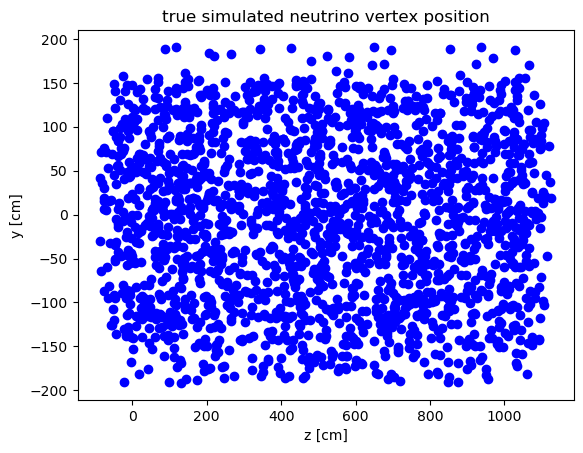

In [19]:
plt.plot(events['nu_vtx_x'],events['nu_vtx_y'],'bo')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.title('true simulated neutrino vertex position')
plt.show()

plt.plot(events['nu_vtx_z'],events['nu_vtx_y'],'bo')
plt.xlabel('z [cm]')
plt.ylabel('y [cm]')
plt.title('true simulated neutrino vertex position')
plt.show()

For one event, we now we explore in detail the different ways the neutrino interaction vertex information is stored.

In [20]:
evt_idx = 5
print('true neutrino interaction pos x=',events['nu_vtx_x'].iloc[evt_idx],' y=',events['nu_vtx_y'].iloc[evt_idx],' z=',events['nu_vtx_z'].iloc[evt_idx],' [cm]')
print('after corrections for space charge distorsions x=',events['nu_vtx_corr_x'].iloc[evt_idx],' y=',events['nu_vtx_corr_y'].iloc[evt_idx],' z=',events['nu_vtx_corr_z'].iloc[evt_idx],' [cm]')
print('in terms of nearest wires on plane0=',events['nu_vtx_wire_pos_0'].iloc[evt_idx],' plane1=',events['nu_vtx_wire_pos_1'].iloc[evt_idx],' plane2=',events['nu_vtx_wire_pos_2'].iloc[evt_idx])

true neutrino interaction pos x= 264.9294  y= -8.772151  z= -4.7897043  [cm]
after corrections for space charge distorsions x= 266.40344  y= -8.858509  z= 2.256616  [cm]
in terms of nearest wires on plane0= 367  plane1= 311  plane2= 7


As a test we can now check that we can reproduce within a wire spacing of 3 mm the corrected vertex position in the YZ plane when computing the wire intersections.

In [21]:
if isPosInActiveVolume(events['nu_vtx_x'].iloc[evt_idx],events['nu_vtx_y'].iloc[evt_idx],events['nu_vtx_z'].iloc[evt_idx]):
    print('YZ plane crossing (planes 0 and 1):',wireCrossingYZ(0,events['nu_vtx_wire_pos_0'].iloc[evt_idx],1,events['nu_vtx_wire_pos_1'].iloc[evt_idx]),' [cm]')
    print('YZ plane crossing (planes 0 and 2):',wireCrossingYZ(0,events['nu_vtx_wire_pos_0'].iloc[evt_idx],2,events['nu_vtx_wire_pos_2'].iloc[evt_idx]),' [cm]')
    print('YZ plane crossing (planes 1 and 2):',wireCrossingYZ(1,events['nu_vtx_wire_pos_1'].iloc[evt_idx],2,events['nu_vtx_wire_pos_2'].iloc[evt_idx]),' [cm]')
else:
    print('The neutirno vertex is not in the active volume, try with a different event.')

The neutirno vertex is not in the active volume, try with a different event.


The next plots explore the simulated neutrino interaction content of the samples. The nue sample is restricted to electron neutirno charged current interactions.

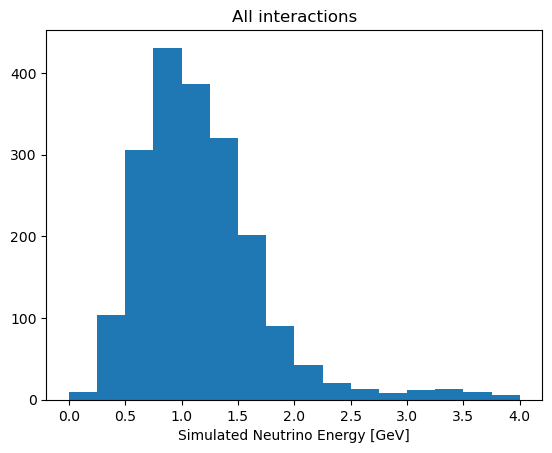

In [22]:
plt.hist(events['nu_energy'],bins=np.linspace(0,4,17))
plt.xlabel('Simulated Neutrino Energy [GeV]')
plt.title('All interactions')
plt.show()

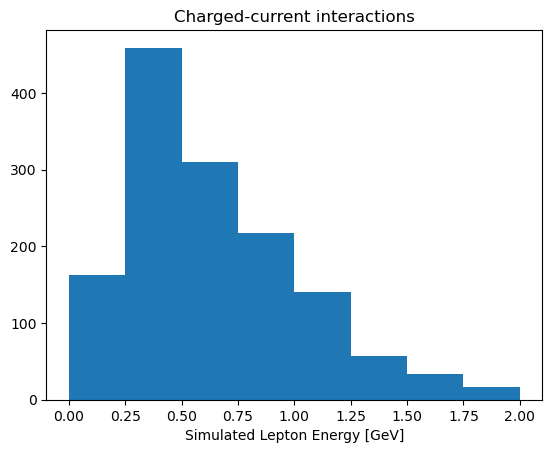

In [23]:
plt.hist(events.query('is_cc==1')['lep_energy'],bins=np.linspace(0,2,9))
plt.xlabel('Simulated Lepton Energy [GeV]')
plt.title('Charged-current interactions')
plt.show()

More detailed information of the simulated particles can be extracted from the particle table

In [24]:
parts = f.get_dataframe_evt('particle_table')
parts.columns

Index(['category', 'end_position_x', 'end_position_y', 'end_position_z',
       'end_position_corr_x', 'end_position_corr_y', 'end_position_corr_z',
       'end_process', 'end_wire_pos_0', 'end_wire_pos_1', 'end_wire_pos_2',
       'end_wire_time', 'g4_id', 'g4_pdg', 'instance', 'momentum', 'parent_id',
       'start_position_x', 'start_position_y', 'start_position_z',
       'start_position_corr_x', 'start_position_corr_y',
       'start_position_corr_z', 'start_process', 'start_wire_pos_0',
       'start_wire_pos_1', 'start_wire_pos_2', 'start_wire_time', 'evt_idx'],
      dtype='object')

In [25]:
primaries = parts[parts['start_process']==b'primary']

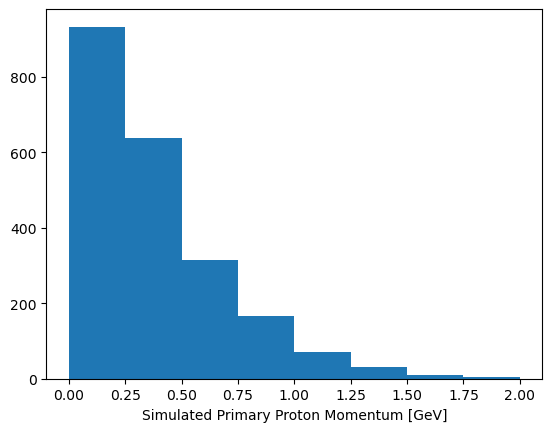

In [26]:
plt.hist(primaries.query('g4_pdg==2212')['momentum'],bins=np.linspace(0,2,9))
plt.xlabel('Simulated Primary Proton Momentum [GeV]')
plt.show()

We can compute the proton multiplicity by counting the number of protons in each event as follows

In [27]:
nprotons_p03 = primaries.query('g4_pdg==2212 and momentum>0.3').groupby(["evt_idx"]).size().reset_index().rename(columns={0:'nprotons_p03'})
events = events.merge(nprotons_p03, on=["evt_idx"], how="left")
events.fillna(0, inplace=True)

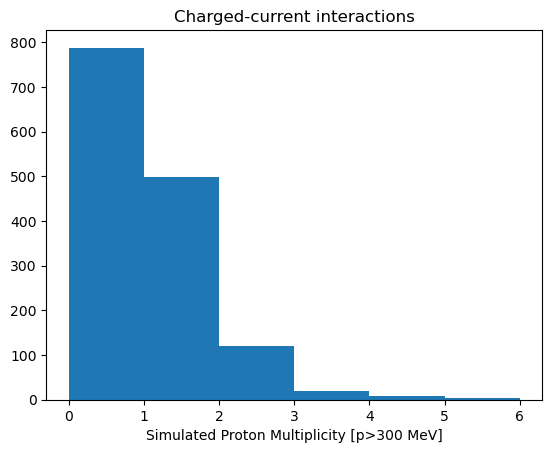

In [28]:
plt.hist(events.query('is_cc==1')['nprotons_p03'],bins=np.linspace(0,6,7))
plt.xlabel('Simulated Proton Multiplicity [p>300 MeV]')
plt.title('Charged-current interactions')
plt.show()